# Import libraries

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import cv2
import pandas as pd

from skimage.io import imread
from skimage.filters import sobel
from skimage.segmentation import felzenszwalb, slic, quickshift, watershed
from skimage.segmentation import mark_boundaries
from skimage.util import img_as_float
from skimage.exposure import rescale_intensity
from skimage import measure
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from scipy.stats import beta
import xlsxwriter

# Logistic Regression

### Read file containing labeled data

In [2]:
df = pd.read_excel("LR training data.xlsx")

### Average values for all columns

In [3]:
df.groupby("Road").mean()

,Red,Green,Blue,Difference_between_red_and_green,Difference_between_the_average_of_red_and_green_and_blue
Road,,,,,
0,143.26475,151.87765,171.06295,31.3746,39.49605
1,64.71160,67.24550,72.19570,3.3500,6.60440


In [4]:
road = df[df.Road==1]
Notroad = df[df.Road==0]

In [5]:
y = df.Road
X = df[["Red", "Green", "Blue", "Difference_between_red_and_green", "Difference_between_the_average_of_red_and_green_and_blue"]]
X.head()

,Red,Green,Blue,Difference_between_red_and_green,Difference_between_the_average_of_red_and_green_and_blue
0,77,176,189,99,62.5
1,69,176,188,107,65.5
2,79,178,193,99,64.5
3,74,174,187,100,63.0
4,73,180,191,107,64.5


In [6]:
X_train, X_test, y_train, y_test = train_test_split(X,y,train_size=0.3)

In [7]:
logreg = LogisticRegression()

In [8]:
logreg.fit(X_train.values, y_train)

LogisticRegression()

# Superpixels

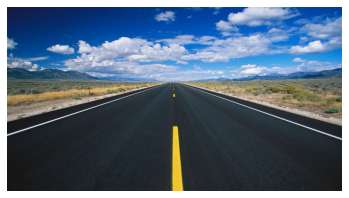

In [9]:
roadOrig = imread('RoadEg3.jpg')
roadCopy = cv2.resize(roadOrig, (1000, 550))
road = cv2.resize(roadOrig, (1000, 550))
roadPredict = cv2.resize(roadOrig, (1000, 550))
roadEdge = cv2.resize(roadOrig, (1000, 550))
img = img_as_float(road)

plt.imshow(road)
plt.axis("off")
plt.show()

### Obtain superpiels from the quickshift alogrithm

Quickshift number of segments: 374


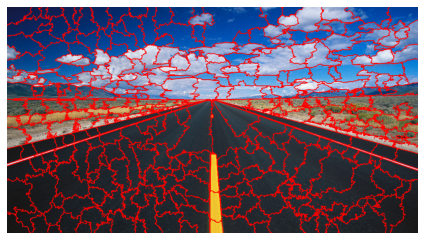

In [10]:
segments_quick = quickshift(img, kernel_size=5, max_dist=22, ratio=1)
print(f"Quickshift number of segments: {len(np.unique(segments_quick))}")

plt.imshow(mark_boundaries(img, segments_quick, (1,0,0)))
plt.axis("off")
plt.tight_layout()
plt.show()

### Obtain a list containing the superpixels that belong to each segment and obatin their RGB values

In [11]:
def sp_idx(s, index = True):
     u = np.unique(s)
     return [np.where(s == i) for i in u]

superpixel_list = sp_idx(segments_quick)
superpixel_RGB_values = [road[idx] for idx in superpixel_list]

### Create a list to store the average RGB values of each super pixel segment

In [12]:
list_of_average_RGB_values = [] 

for i in range(0, len(superpixel_RGB_values)):
    average_RGB_intensity = np.average(superpixel_RGB_values[i], axis=0)
    list_of_average_RGB_values.append(average_RGB_intensity)

### Create a list to store segments that are not road according to average RGB values

In [13]:
segmentNotRoad = []

for i in range(len(list_of_average_RGB_values)):
    if logreg.predict_proba([[list_of_average_RGB_values[i][0], list_of_average_RGB_values[i][1], list_of_average_RGB_values[i][2], 
                        abs(int(list_of_average_RGB_values[i][0])-int(list_of_average_RGB_values[i][1])),
                       abs(((int(list_of_average_RGB_values[i][0]) + int(list_of_average_RGB_values[i][1]))/2) - int(list_of_average_RGB_values[i][2]))]])[0][1] > 0.5:
        segmentNotRoad.append(i)

### Only show superpixels predicted to contain road

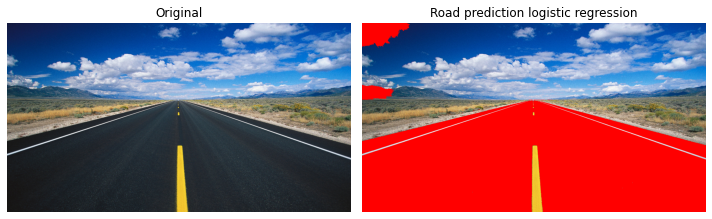

In [14]:
roadPredict = cv2.resize(roadOrig, (1000, 550))

for i in segmentNotRoad: 
    for j in range(0, len(superpixel_list[i][0])): 
        #roadPredict[superpixel_list[i][0][j]][superpixel_list[i][1][j]][:] = 255
        roadPredict[superpixel_list[i][0][j]][superpixel_list[i][1][j]][0] = 255
        roadPredict[superpixel_list[i][0][j]][superpixel_list[i][1][j]][1] = 0
        roadPredict[superpixel_list[i][0][j]][superpixel_list[i][1][j]][2] = 0

fig, ax = plt.subplots(1, 2, figsize=(10, 10), sharex=True, sharey=True)

ax[0].imshow(img)
ax[0].set_title("Original")
ax[1].imshow(roadPredict)
ax[1].set_title("Road prediction logistic regression")
#ax[1].imshow(mark_boundaries(img, segments_quick))
#ax[1].set_title("Original")

for a in ax.ravel():
    a.set_axis_off()

plt.tight_layout()
plt.show()

# Beta Distribution of Logistic Regression

### Create a list storing the probability that a superpixel is road from logistic regression

In [15]:
LR_road_proba = []

for i in range(len(list_of_average_RGB_values)):
    LR_road_proba.append(logreg.predict_proba([[list_of_average_RGB_values[i][0], list_of_average_RGB_values[i][1], list_of_average_RGB_values[i][2], 
                            abs(int(list_of_average_RGB_values[i][0])-int(list_of_average_RGB_values[i][1])),
                           abs(((int(list_of_average_RGB_values[i][0]) + int(list_of_average_RGB_values[i][1]))/2) - int(list_of_average_RGB_values[i][2]))]])[0][1])

### Create a list of probalilites a superpixel does not belong to road

In [16]:
list_probas_segment_is_not_road = []

for i in range(0, len(list_of_average_RGB_values)):
     if logreg.predict([[list_of_average_RGB_values[i][0], list_of_average_RGB_values[i][1], list_of_average_RGB_values[i][2], 
                        abs(int(list_of_average_RGB_values[i][0])-int(list_of_average_RGB_values[i][1])),
                       abs(((int(list_of_average_RGB_values[i][0]) + int(list_of_average_RGB_values[i][1]))/2) - int(list_of_average_RGB_values[i][2]))]]) == 0:
            
        list_probas_segment_is_not_road.append(logreg.predict_proba([[list_of_average_RGB_values[i][0], list_of_average_RGB_values[i][1], list_of_average_RGB_values[i][2], 
                            abs(int(list_of_average_RGB_values[i][0])-int(list_of_average_RGB_values[i][1])),
                           abs(((int(list_of_average_RGB_values[i][0]) + int(list_of_average_RGB_values[i][1]))/2) - int(list_of_average_RGB_values[i][2]))]])[0][1])
        
        list_probas_segment_is_not_road.append(logreg.predict_proba([[list_of_average_RGB_values[i][0], list_of_average_RGB_values[i][1], list_of_average_RGB_values[i][2], 
                            abs(int(list_of_average_RGB_values[i][0])-int(list_of_average_RGB_values[i][1])),
                       abs(((int(list_of_average_RGB_values[i][0]) + int(list_of_average_RGB_values[i][1]))/2) - int(list_of_average_RGB_values[i][2]))]])[0][0])

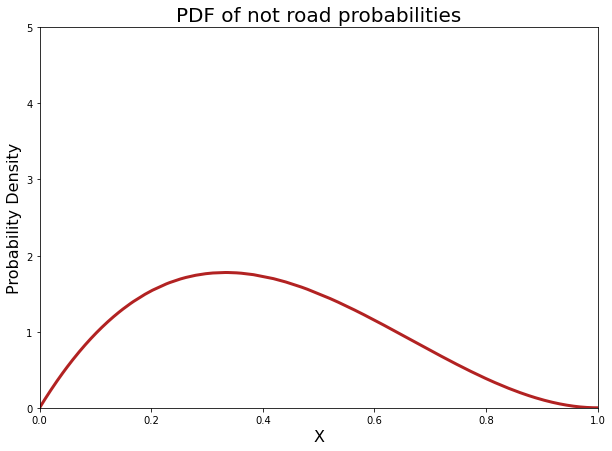

In [17]:
beta_prob_not_road = []

plt.rcParams['figure.figsize'] = [10, 7]

list_probas_segment_is_not_road.sort()
x = list_probas_segment_is_not_road
y = beta.pdf(x, 2, 3)

plt.title("PDF of not road probabilities", fontsize=20)
plt.xlabel("X", fontsize=16)
plt.ylabel("Probability Density", fontsize=16)
plt.plot(x, y, linewidth=3, color='firebrick')
plt.ylim([0, 5])
plt.xlim([0, 1])
plt.show()

for i in range(len(LR_road_proba)):
    beta_prob_not_road.append(np.interp(LR_road_proba[i], x,y))

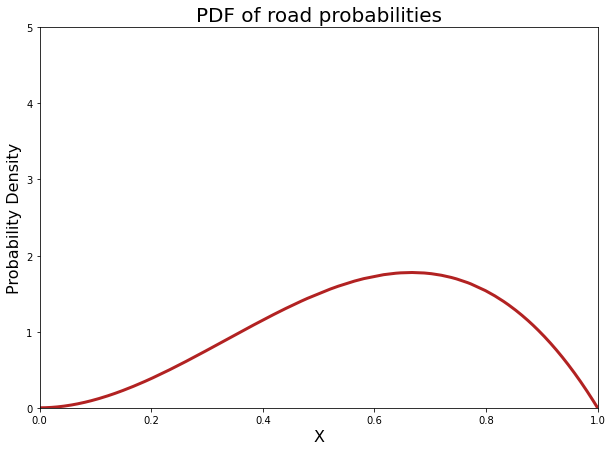

In [18]:
beta_prob_road = []

plt.rcParams['figure.figsize'] = [10, 7]

list_probas_segment_is_not_road.sort()
x = list_probas_segment_is_not_road
y = beta.pdf(x, 3, 2)

plt.title("PDF of road probabilities", fontsize=20)
plt.xlabel("X", fontsize=16)
plt.ylabel("Probability Density", fontsize=16)
plt.plot(x, y, linewidth=3, color='firebrick')
plt.ylim([0, 5])
plt.xlim([0, 1])
plt.show()

for i in range(len(LR_road_proba)):
    beta_prob_road.append(np.interp(LR_road_proba[i], x,y))

### Normalize Beta probabilities

In [19]:
normalized_beta_road = []
normalized_beta_not_road = []

for i in range(len(beta_prob_road)):
    normalize_factor = beta_prob_road[i] + beta_prob_not_road[i]
    normalized_beta_road.append(beta_prob_road[i]/(beta_prob_road[i] + beta_prob_not_road[i]))
    normalized_beta_not_road.append(beta_prob_not_road[i]/(beta_prob_road[i] + beta_prob_not_road[i]))

### Create an Excel Spreadsheet with normalized beta probabilites to use in the PGM 

In [20]:
workbook = xlsxwriter.Workbook('road probas.xlsx')
worksheet = workbook.add_worksheet("Normalized beta road")
 
# Start from the first cell. 
#Rows and columns are zero indexed.
row = 0
col = 0
 
# Iterate over the data and write it out row by row.
for i in range(len(normalized_beta_road)):
        worksheet.write(row, col, normalized_beta_road[i])
        row += 1
 
workbook.close()

In [21]:
workbook = xlsxwriter.Workbook('not road probas.xlsx')
worksheet = workbook.add_worksheet("Normalized beta not road")
 
# Start from the first cell. 
#Rows and columns are zero indexed.
row = 0
col = 0
 
# Iterate over the data and write it out row by row.
for i in range(len(normalized_beta_not_road)):
        worksheet.write(row, col, normalized_beta_not_road[i])
        row += 1
 
workbook.close()

### Read in the results obtained from the PGM 

In [22]:
from openpyxl import load_workbook
wb = load_workbook("PGM prediction.xlsx")  # Work Book
ws = wb['Sheet1']  # Work Sheet
column = ws['A']  # Column
column_list = [column[x].value for x in range(len(column))]

### Show superpixels predicted to be road from PGM

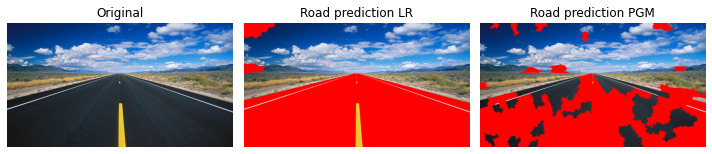

In [23]:
roadGuess = cv2.resize(roadOrig, (1000, 550))

for i in range(len(column_list)):
    if float(column_list[i]) > 0.5:
        for j in range(len(superpixel_list[i][0])): 
            #roadGuess[superpixel_list[i][0][j]][superpixel_list[i][1][j]][:] = 255
            roadGuess[superpixel_list[i][0][j]][superpixel_list[i][1][j]][0] = 255
            roadGuess[superpixel_list[i][0][j]][superpixel_list[i][1][j]][1] = 0
            roadGuess[superpixel_list[i][0][j]][superpixel_list[i][1][j]][2] = 0
               
fig, ax = plt.subplots(1, 3, figsize=(10, 10), sharex=True, sharey=True)

ax[0].imshow(road)
#ax[0].imshow(mark_boundaries(road, segments_quick, color=(1, 0, 0)))
ax[0].set_title("Original")
ax[1].imshow(roadPredict)
#ax[1].imshow(mark_boundaries(roadPredict, segments_quick, color=(1, 0, 0)))
ax[1].set_title("Road prediction LR")
ax[2].imshow(roadGuess)
#ax[2].imshow(mark_boundaries(roadGuess, segments_quick, color=(1, 0, 0)))
ax[2].set_title("Road prediction PGM")

for a in ax.ravel():
    a.set_axis_off()

plt.tight_layout()
plt.show()

# Canny Edge Detector 

In [24]:
grayRoad = cv2.cvtColor(road, cv2.COLOR_RGB2GRAY)
blurGrayRoad = cv2.GaussianBlur(grayRoad, (5,5), 0)
cannyResult = cv2.Canny(blurGrayRoad, 50, 200)

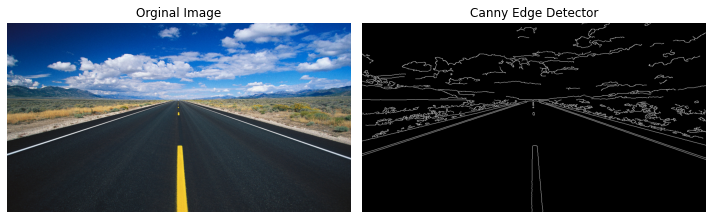

In [25]:
fig, ax = plt.subplots(1, 2, figsize=(10, 10), sharex=True, sharey=True)

ax[0].imshow(roadCopy)
ax[0].set_title("Orginal Image")
ax[1].imshow(cannyResult, cmap = 'gray')
ax[1].set_title("Canny Edge Detector")

for a in ax.ravel():
    a.set_axis_off()

plt.tight_layout()
plt.show()

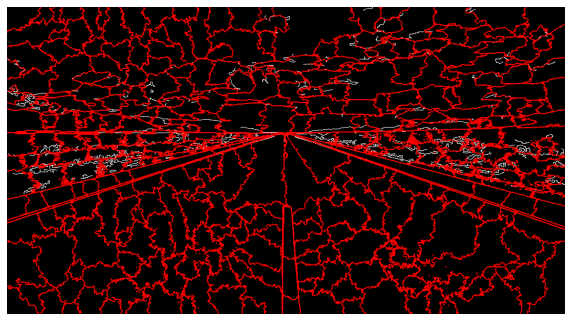

In [26]:
plt.imshow(mark_boundaries(cannyResult, segments_quick, color=(1, 0, 0)), cmap='gray')
plt.axis("off")
plt.show()

### Neighbours of a superpixel

In [27]:
neighbours = []
list_of_neighbours = []


for segments in range(len(np.unique(segments_quick))):
    for i in range(len(segments_quick)-1):
            for j in range(len(segments_quick[0])-1):
                if segments_quick[i][j] == segments:
                    if segments_quick[i+1][j] != segments_quick[i][j]:
                        neighbours.append(segments_quick[i+1][j])
                    if segments_quick[i][j+1] != segments_quick[i][j]:
                        neighbours.append(segments_quick[i][j+1])
    
    list_of_neighbours.append(np.unique(neighbours))
    neighbours = []

## Determine if there is an edge between a superpixel and its neighbours

### Obtain a list indicating whether there is an edge between a superpixel and its neighbour

In [29]:
pixels_between_neighbour_row_index = []
pixels_between_neighbour_column_index = []
edge_pixels_between_superpixels = []
edge_between_superpixels = []
edge = []

for segment in range(len(np.unique(segments_quick))):
    for segmentNeighbours in range(len(list_of_neighbours[segment])):
        for i in range(len(segments_quick)-1):
                for j in range(len(segments_quick[0])-1):
                    if segments_quick[i][j] == segment:
                        if segments_quick[i+1][j] == list_of_neighbours[segment][segmentNeighbours]:
                            pixels_between_neighbour_row_index.append(i-1)
                            pixels_between_neighbour_row_index.append(i)
                            pixels_between_neighbour_row_index.append(i+1)
                            pixels_between_neighbour_column_index.append(j)
                            pixels_between_neighbour_column_index.append(j)
                            pixels_between_neighbour_column_index.append(j)
                        if segments_quick[i][j+1] == list_of_neighbours[segment][segmentNeighbours]:
                            pixels_between_neighbour_row_index.append(i)
                            pixels_between_neighbour_row_index.append(i)
                            pixels_between_neighbour_row_index.append(i)
                            pixels_between_neighbour_column_index.append(j-1)
                            pixels_between_neighbour_column_index.append(j)
                            pixels_between_neighbour_column_index.append(j+1)

        for index in range(len(pixels_between_neighbour_row_index)):
            if cannyResult[pixels_between_neighbour_row_index[index]][pixels_between_neighbour_column_index[index]] == 255:
                edge_pixels_between_superpixels.append(1)

        pixels_between_neighbour_row_index = []   
        pixels_between_neighbour_column_index = []
        if len(edge_pixels_between_superpixels)>15: #Probably better to use a percentage (eg if more than 20 percent of pixels between two superpicels are edge pixels then there is an edge between the 2 superpixels)  
            edge_between_superpixels.append(1)
        else:
            edge_between_superpixels.append(0)   

        edge_pixels_between_superpixels = []

    edge.append(edge_between_superpixels)
    edge_between_superpixels = []

### Create a list storing superpixels have an edge between any neighbours

In [31]:
EdgeSuperpixels = []
edgeFlag = 0

for i in range(len(edge)):
    for j in range(len(edge[i])):
        if edge[i][j] == 1:
            edgeFlag += 1
    
    if edgeFlag > 0:
        EdgeSuperpixels.append(i)
    edgeFlag = 0 

### Show superpixels that don't edges between themselves and neighbouring superpixels 

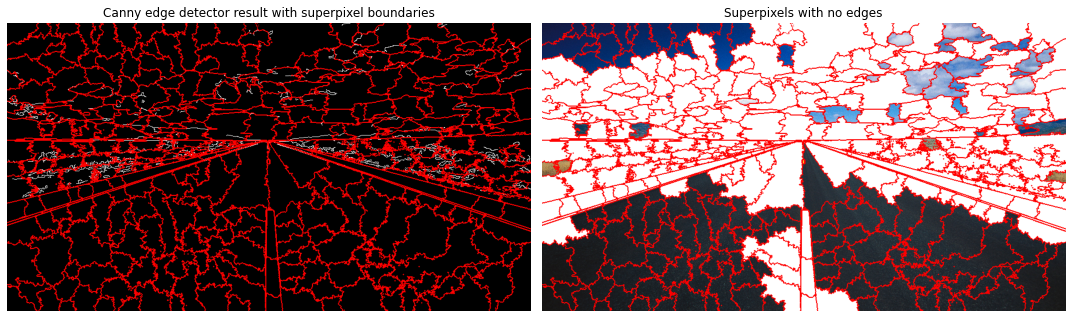

In [32]:
for i in EdgeSuperpixels: 
    for j in range(len(superpixel_list[i][0])): 
        roadEdge[superpixel_list[i][0][j]][superpixel_list[i][1][j]][:] = 255 #roadPredict[superpixel_list[i][0][j]][superpixel_list[i][1][j]][:] = 255

fig, ax = plt.subplots(1, 2, figsize=(15, 15), sharex=True, sharey=True)

#ax[0].imshow(cannyResult, cmap='gray')
ax[0].imshow(mark_boundaries(cannyResult, segments_quick, color=(1, 0, 0) ))
ax[0].set_title("Canny edge detector result with superpixel boundaries")
#ax[1].imshow(roadEdge)
ax[1].imshow(mark_boundaries(roadEdge, segments_quick, color=(1, 0, 0)))
ax[1].set_title("Superpixels with no edges")

for a in ax.ravel():
    a.set_axis_off()

plt.tight_layout()
plt.show()        

### Create an excel spreadsheet containing the neighbours each superpixel

In [33]:
workbook = xlsxwriter.Workbook('Neighbours of superpixel.xlsx')
worksheet = workbook.add_worksheet("Neighbours of superpixel")
 
# Start from the first cell. 
#Rows and columns are zero indexed.
row = 0
col = 0
 
# Iterate over the data and write it out row by row.
for i in range(len(list_of_neighbours)):
    for j in range(len(list_of_neighbours[i])):
        worksheet.write(row, col, list_of_neighbours[i][j])
        col += 1
    col = 0
    row += 1
workbook.close()

### Create an excel spreadsheet indicating whether there is an edge between a superpixel and each of its neighbours 

In [34]:
workbook = xlsxwriter.Workbook('Edges between superpixel and its neighbours.xlsx')
worksheet = workbook.add_worksheet("Edges between superpixels")
 
# Start from the first cell. 
#Rows and columns are zero indexed.
row = 0
col = 0
 
# Iterate over the data and write it out row by row.
for i in range(len(edge)):
    for j in range(len(edge[i])):
        worksheet.write(row, col, edge[i][j])
        col += 1
    col = 0
    row += 1
workbook.close()